In [1]:
# reload
%load_ext autoreload
%autoreload 2

In [52]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import funPlots as fplot

import seaborn as sns
from scipy.stats import entropy


def load_matplotlib_local_fonts():
    from matplotlib import font_manager
    
    font_path = '/home/barzon/Avenir.ttc'
    
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    #  Set it as default matplotlib font
    plt.rcParams.update({
        'font.sans-serif': prop.get_name(),
    })
    
load_matplotlib_local_fonts()

fplot.master_format(ncols = 2, nrows = 1)

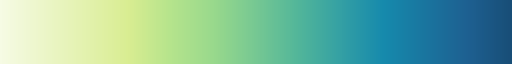

In [53]:
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["#F6FBE4", "#ECF6C9", "#E3F2AE", "#d9ed92", "#b5e48c", "#99d98c",
          "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77"]
nodes = np.linspace(0, 1, len(colors))
cmap_SR = LinearSegmentedColormap.from_list("cmap_SR", list(zip(nodes, colors)))
cmap_SR.set_bad(color='w')
cmap_SR

In [54]:
from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps, MC_underhood)
from utils.analytical import *

def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r}

In [55]:
data_folder = 'data/'

mutuals = np.load(data_folder+'mutual_importance_sampling.npy')
my_cmap_continuous = sns.color_palette('mako_r', as_cmap=True)

colors = ("#76c893", "#184e77")
labels = ('$E$', '$I$')

In [56]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 1.
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [57]:
### Define grid params
kmin, kmax = 0., 5
wmin, wmax = 0.01, 10

nk, nw = int(2e2), int(2e2)

k_list, w_list = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

Ws, Ks = np.meshgrid(w_list, k_list)

In [58]:
np.nanmin(mutuals), np.nanmax(mutuals)

(0.7464735023716894, 1.0430062884737181)

In [59]:
w = 10
mutual_line_10_logspace = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_logspace.npy')
k_list_10_logspace = np.load(data_folder+f'k_list_fixedw{w}_logspace.npy')
bounds_up_10_logspace = np.load(data_folder+f'bounds_up_fixedw{w}_logspace.npy')
bounds_down_10_logspace = np.load(data_folder+f'bounds_down_fixedw{w}_logspace.npy')

mutual_line_10 = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}.npy')
k_list_10 = np.load(data_folder+f'k_list_fixedw{w}.npy')
bounds_up_10 = np.load(data_folder+f'bounds_up_fixedw{w}.npy')
bounds_down_10 = np.load(data_folder+f'bounds_down_fixedw{w}.npy')

w = 1.05
mutual_line_1_logspace = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_logspace.npy')
k_list_1_logspace = np.load(data_folder+f'k_list_fixedw{w}_logspace.npy')
bounds_up_1_logspace = np.load(data_folder+f'bounds_up_fixedw{w}_logspace.npy')
bounds_down_1_logspace = np.load(data_folder+f'bounds_down_fixedw{w}_logspace.npy')

mutual_line_1 = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}.npy')
k_list_1 = np.load(data_folder+f'k_list_fixedw{w}.npy')
bounds_up_1 = np.load(data_folder+f'bounds_up_fixedw{w}.npy')
bounds_down_1 = np.load(data_folder+f'bounds_down_fixedw{w}.npy')

k_crit_10 = 1 - 1 / 10
k_crit_1 = 1 - 1 / 1.05

In [60]:
ks = np.load(data_folder+f'k_list_nonlinear.npy')
ks_large = np.load(data_folder+f'k_list_nonlinear_large.npy')
n_runs = 10
tau_hs = [1000, 250] #[1000, 500, 250]
ws = [1, 2, 4, 6]
D = 0.05

res_linear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))
res_nonlinear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))

for ih, tau_h in enumerate(tau_hs):
    for iw, w in enumerate(ws):
        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        
        res_linear[ih,iw] = tmp_res_linear
        res_nonlinear[ih,iw] = tmp_res_nonlinear
        
mi_imp_samp = np.zeros((len(ws), ks_large.size))

for i, w in enumerate(ws):
    mi_importance_sampling = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_deltah_{delta_h}_D_{D}.npy')
    mi_imp_samp[i] = mi_importance_sampling

In [61]:
Hinput = entropy(p_stat)/np.log(2)
Hinput

1.584962500721156

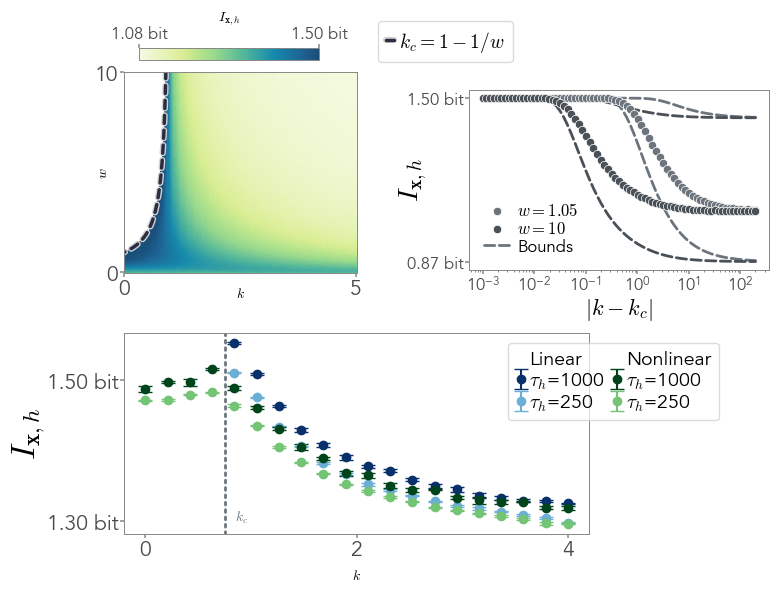

In [94]:
cmaps_lin = plt.get_cmap('Blues_r',len(tau_hs)+1)
cmaps_nonlin = plt.get_cmap('Greens_r',len(tau_hs)+1)

idx_w = 2

fig, axs = plt.subplot_mosaic([["CP", "."],
                               ["MI", "MI"]],
                               figsize = (6, 6),
                               gridspec_kw = {'height_ratios': [1,1]})
plt.subplots_adjust(hspace=0.3, wspace=0.)
axs["CP"].pcolor(Ks, Ws, mutuals.T/np.log(2), cmap=cmap_SR, rasterized = True, shading = 'auto')
axs["CP"].plot(1-1/w_list, w_list, ls = '--', color='#2b2d42', lw=2.5, label = "$k_c = 1 - 1/w$",
               path_effects=[pe.Stroke(linewidth=4.5, foreground='lightgray'), pe.Normal()],
               dashes=[2.3, 2])

axs["CP"].set_xlim(kmin,None)

axs["CP"].set_xlabel('$k$', labelpad = -10)
axs["CP"].set_ylabel('$w$', labelpad = -12)
axs["CP"].set_xticks([0, 5])
axs["CP"].set_yticks([0, 10])

axs["CP"].legend(fontsize = 14, bbox_to_anchor=(1.05, 1.3), loc='upper left')

cax = fig.add_axes([0.15, 0.9, 0.3, 0.02])
cbar = plt.colorbar(axs["CP"].collections[0], cax=cax, orientation='horizontal', label = r'$I_{\mathbf{x},h}$')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

min_mutual = np.nanmin(mutuals)/np.log(2)
max_mutual = np.nanmax(mutuals)/np.log(2)

cbar.set_ticks([min_mutual , max_mutual])
cbar.set_ticklabels([f'{min_mutual:.2f} bit', f'{max_mutual:.2f} bit'], fontsize = 12)

dummy1 = axs["MI"].plot([], [], linestyle='None', label='Linear', color='none')
for j, tau_h in enumerate(tau_hs):
    axs["MI"].errorbar(ks, res_linear[j,idx_w].mean(axis=1), res_linear[j,idx_w].std(axis=1) / np.sqrt(res_linear[j,idx_w].shape[1]), label=r'$\tau_h$='+str(tau_h), fmt='o', capsize=5, c=cmaps_lin(j))

dummy2 = axs["MI"].plot([], [], linestyle='None', label='Nonlinear', color='none')
for j, tau_h in enumerate(tau_hs):
    axs["MI"].errorbar(ks, res_nonlinear[j,idx_w].mean(axis=1), res_nonlinear[j,idx_w].std(axis=1) / np.sqrt(res_linear[j,idx_w].shape[1]), label=r'$\tau_h$='+str(tau_h), fmt='o', capsize=5, c=cmaps_nonlin(j))

#axs["MI"].plot(ks_large, mi_imp_samp[idx_w] / np.log(2), color = "#6c757d", lw = 3, label = f"$w = {ws[idx_w]}$")
axs["MI"].axvline(1 - 1/ws[idx_w], color = "#6c757d", lw = 2, ls = 'dotted')
axs["MI"].text(1 - 1/ws[idx_w] + 0.1, np.nanmin(res_linear[j,idx_w]) + 0.01, r'$k_c$', color = "#6c757d")

#axs["MI"].hlines(Hinput, -0.1, 4.1, color = '#6c757d', ls = '--', lw = 2, zorder = -np.inf, label='$H_{input}$')

axs["MI"].set_xlabel('$k$', labelpad = 5)
axs["MI"].set_ylabel('$I_{\mathbf{x},h}$', labelpad = 0, fontsize = 24)

axs["MI"].set_xticks([0, 2, 4])
axs["MI"].set_yticks([1.3, 1.5])
axs["MI"].set_yticklabels([f'{1.3:.2f} bit', f'{1.5:.2f} bit'])


handles, labels = axs["MI"].get_legend_handles_labels()
order = [0,2,3,1,4,5]
axs["MI"].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize = 14, bbox_to_anchor=(1.3, 1.), loc='upper right', ncol=2)

ax_inset = fig.add_axes([0.7, 0.55, 0.5, 0.3])
ax_inset.scatter(k_list_1_logspace - k_crit_1, mutual_line_1_logspace/np.log(2), color = "#6c757d", lw = 0.5, ec = "w", label = "$w = 1.05$")
ax_inset.scatter(k_list_10_logspace - k_crit_10, mutual_line_10_logspace/np.log(2), color = "#495057", lw = 0.5, ec = "w", label = "$w = 10$")

ax_inset.plot(k_list_1_logspace - k_crit_1, bounds_up_1_logspace/np.log(2), color = "#6c757d", lw = 2, ls = '--', zorder = -np.inf, label = "Bounds")
ax_inset.plot(k_list_1_logspace - k_crit_1, bounds_down_1_logspace/np.log(2), color = "#6c757d", lw = 2, ls = '--', zorder = -np.inf)

ax_inset.plot(k_list_10_logspace - k_crit_10, bounds_up_10_logspace/np.log(2), color = "#495057", lw = 2, ls = '--', zorder = -np.inf)
ax_inset.plot(k_list_10_logspace - k_crit_10, bounds_down_10_logspace/np.log(2), color = "#495057", lw = 2, ls = '--', zorder = -np.inf)

ax_inset.legend(fontsize = 12, loc = 'lower left', handlelength = 1.5, handletextpad = 0.5, frameon = False)

ax_inset.tick_params(axis='both', which='major', labelsize=12)

ax_inset.set_xscale('log')
ax_inset.set_yticks([0.87, 1.5])
ax_inset.set_yticklabels([f'{0.87:.2f} bit', f'{1.5:.2f} bit'])
ax_inset.set_xlabel('$|k - k_c|$', labelpad = 0, fontsize = 16)
ax_inset.set_ylabel('$I_{\mathbf{x},h}$', labelpad = -16, fontsize = 20)
fplot.restore_log_ticks(ax_inset.xaxis, 10)

#plt.savefig('figures/Figure2_draft.svg', dpi = 300, bbox_inches = 'tight')
plt.show()